In [41]:
import tensorflow
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow.keras as keras
from matplotlib import pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.datasets import make_friedman3, make_friedman2, make_friedman1
from tensorflow.keras.layers.experimental.preprocessing import Normalization

In [2]:
x, y = make_friedman2(n_samples=100, noise=0.2, random_state=3)

n_train = 70
x_train, x_test = x[:n_train, :], x[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

Text(0.5, 1.0, 'y')

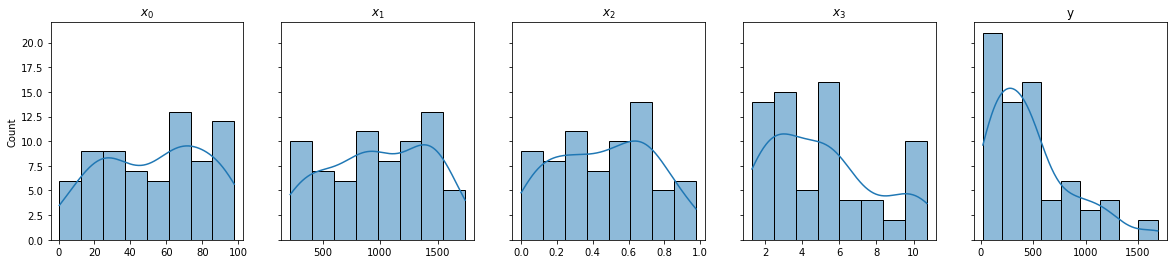

In [3]:
fig, ax = plt.subplots(ncols = x_train.shape[1] + 1 , figsize=((x_train.shape[1] + 1) * 4, 4), sharey=True)
for i, a in enumerate(ax[:-1]):
    sns.histplot(x_train[:,i], kde=True, ax = a)
    a.set_title(f'$x_{i}$')

sns.histplot(y_train, kde=True, ax = ax[-1])
ax[-1].set_title('y')

In [4]:
def make_model():
    model = Sequential()
    model.add(Dense(100, input_dim=4, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam')
    return model

In [5]:
model = make_model()
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=1000, verbose=0)
train_err = model.evaluate(x_train, y_train, verbose=0)
test_err = model.evaluate(x_test, y_test, verbose=0)
print('Ошибка на обучающей выборке: %.3f, ошибка на тестовой выборке: %.3f' % (train_err, test_err))

Ошибка на обучающей выборке: 93166.445, ошибка на тестовой выборке: 73444.125


In [6]:
def plot_history(history=history):
    fig, ax = plt.subplots(figsize=(15, 4), sharex=True)
    ax.plot(history.history['loss'], label='Обучающая выборка')
    ax.plot(history.history['val_loss'], label='Тестовая выборка')
    ax.set_ylabel('MSE')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True)
    plt.show()

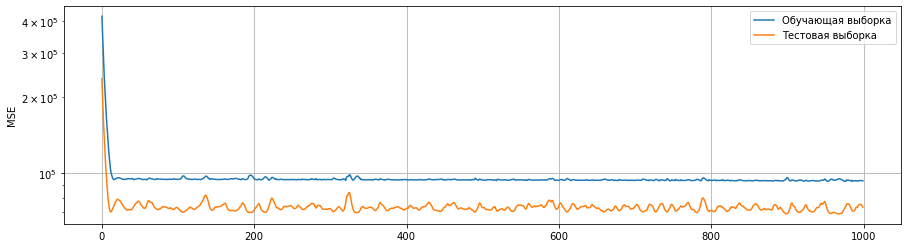

In [7]:
plot_history(history)

In [8]:
normLayer = Normalization()
normLayer.adapt(x_train)
pd.DataFrame(normLayer(x_train).numpy()).describe()

,0,1,2,3
count,7.000000e+01,7.000000e+01,7.000000e+01,7.000000e+01
mean,2.895083e-08,4.768372e-08,2.916370e-08,1.144196e-09
std,1.007220e+00,1.007220e+00,1.007220e+00,1.007220e+00
min,-1.841497e+00,-1.748861e+00,-1.719685e+00,-1.348178e+00
25%,-8.873548e-01,-8.653410e-01,-7.891770e-01,-8.598292e-01
50%,8.971535e-02,4.086886e-02,8.492380e-02,1.063695e-02
75%,7.235489e-01,9.156908e-01,8.202483e-01,6.092526e-01
max,1.548643e+00,1.716112e+00,1.866966e+00,2.001349e+00


In [9]:
def make_model_2():
    model = Sequential()
    normLayer = Normalization()
    normLayer.adapt(x_train)
    model.add(normLayer)
    model.add(Dense(100, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer= keras.optimizers.SGD(learning_rate=0.001))
    return model

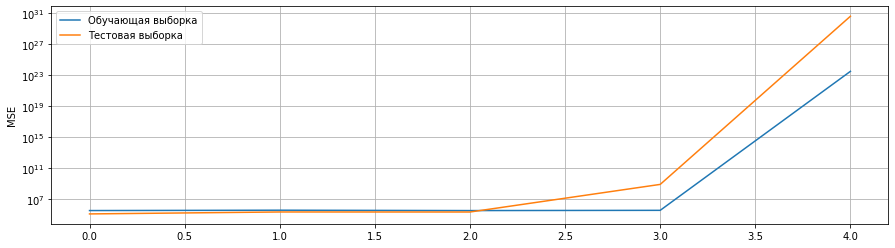

In [10]:
model2 = make_model_2()
history = model2.fit(x_train, y_train,
                     validation_data=(x_test, y_test),
                     epochs=1500,
                     verbose=0)

plot_history(history)

In [11]:
def make_model_2b():
    model = Sequential()
    normLayer = Normalization()
    normLayer.adapt(x_train)
    model.add(normLayer)
    model.add(Dense(100, activation='tanh'))
    model.add(Dense(30, activation='tanh'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer= keras.optimizers.SGD(learning_rate=0.001))
    return model

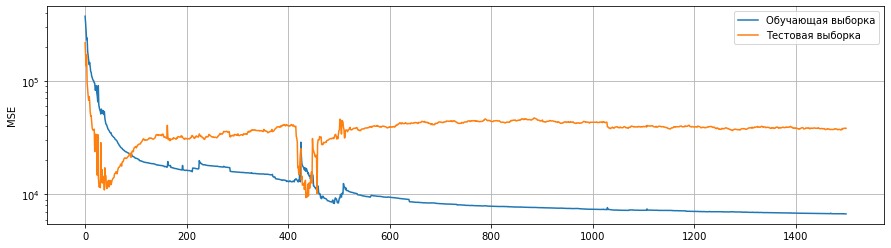

In [12]:
model2b = make_model_2b()
history = model2b.fit(x_train, y_train,
                     validation_data=(x_test, y_test),
                     epochs=1500,
                     verbose=0)

plot_history(history)

**Задание 1**

Для нормализации выходных данных был использован метод минимакс. На мой взгляд, получившийся результат не хуже чем в примере: выходные данные приобрели хороший вид, выровнялись ошибки на выборках - на обучающей ошибка выше, на тестовой - ниже.

In [13]:
def min_max(z, z_min, z_max):
    return (z - z_min) / (z_max - z_min)

def normalize(y, y_train):
    statistics = pd.DataFrame(y_train).describe()
    y_min = statistics.iloc[3][0]
    y_max = statistics.iloc[7][0]
    return min_max(y, y_min, y_max)

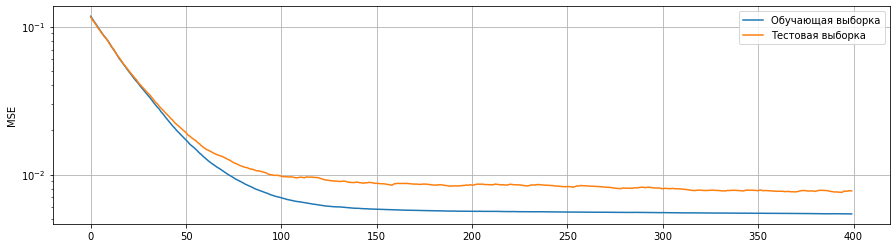

In [14]:
model2c = make_model_2b()
history = model2c.fit(x_train, normalize(y_train, y_train),
                     validation_data=(x_test, normalize(y_test, y_train)),
                     epochs=400,
                     verbose=0)
plot_history(history)

<AxesSubplot:ylabel='Count'>

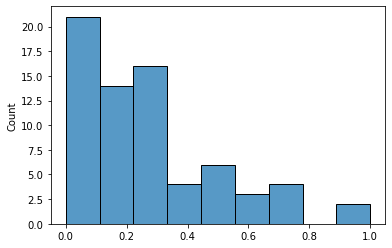

In [15]:
sns.histplot(normalize(y_train, y_train))

In [16]:
train_err_1 = model2c.evaluate(x_train, normalize(y_train, y_train), verbose=0)
test_err_1 = model2c.evaluate(x_test, normalize(y_test, y_train), verbose=0)

print('Ошибка на обучающей выборке: %.3f, ошибка на тестовой выборке: %.3f' % (train_err_1, test_err_1))

Ошибка на обучающей выборке: 0.005, ошибка на тестовой выборке: 0.008


In [17]:
def make_model_3():
    model = Sequential()
    normLayer = Normalization()
    normLayer.adapt(x_train)
    model.add(normLayer)
    model.add(Dense(100, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer= keras.optimizers.Adam(learning_rate=0.001))
    return model

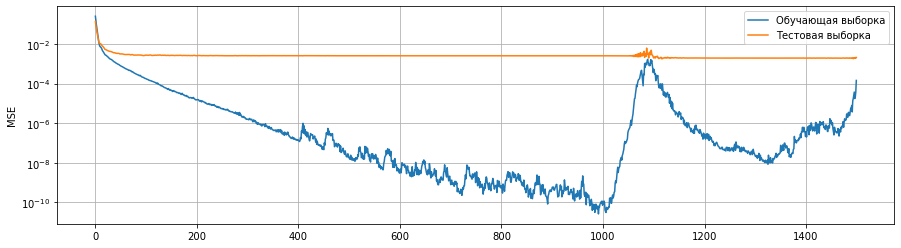

In [18]:
model3 = make_model_3()
history = model3.fit(x_train, normalize(y_train, y_train),
                     validation_data=(x_test, normalize(y_test, y_train)),
                     epochs=1500,
                     verbose=0)
plot_history(history)

In [19]:
train_err_2 = model3.evaluate(x_train, normalize(y_train, y_train), verbose=0)
test_err_2 = model3.evaluate(x_test, normalize(y_test, y_train), verbose=0)

print('Ошибка на обучающей выборке: %.3f, ошибка на тестовой выборке: %.3f' % (train_err_2, test_err_2))

Ошибка на обучающей выборке: 0.000, ошибка на тестовой выборке: 0.002


In [20]:
def scheduler(epoch, lr):               
    if epoch < 10:                                    
        return lr
    else:
        return lr * tensorflow.math.exp(-0.01)       

In [21]:
def make_model_3b():
    model = Sequential()
    normLayer = Normalization()
    normLayer.adapt(x_train)
    model.add(normLayer)
    model.add(Dense(100, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer= keras.optimizers.Adam(learning_rate=0.001))
    return model

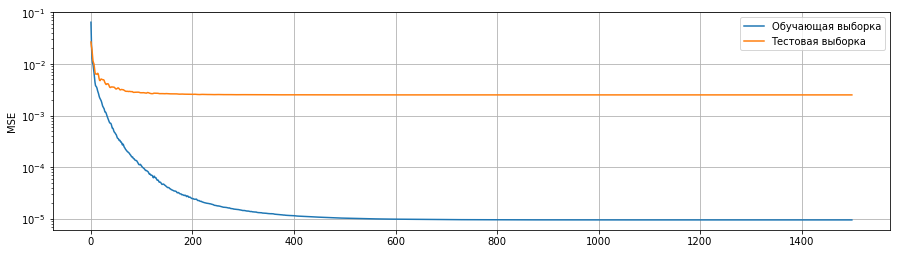

In [22]:
lr = LearningRateScheduler(scheduler)

model3 = make_model_3()
history = model3.fit(x_train, normalize(y_train, y_train),
                     validation_data=(x_test, normalize(y_test, y_train)),
                     epochs=1500,
                     verbose=0,
                     callbacks=[lr])
plot_history(history)

In [23]:
train_err_3 = model3.evaluate(x_train, normalize(y_train, y_train), verbose=0)
test_err_3 = model3.evaluate(x_test, normalize(y_test, y_train), verbose=0)

print('Ошибка на обучающей выборке: %.3f, ошибка на тестовой выборке: %.3f' % (train_err_3, test_err_3))

Ошибка на обучающей выборке: 0.000, ошибка на тестовой выборке: 0.003


In [24]:
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [25]:
def make_model_4():
    model = Sequential()
    normLayer = Normalization()
    normLayer.adapt(x_train)
    model.add(normLayer)
    model.add(Dense(100, activation='tanh'))
    model.add(Dense(30, activation='tanh'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer= keras.optimizers.SGD(learning_rate=0.001))
    return model

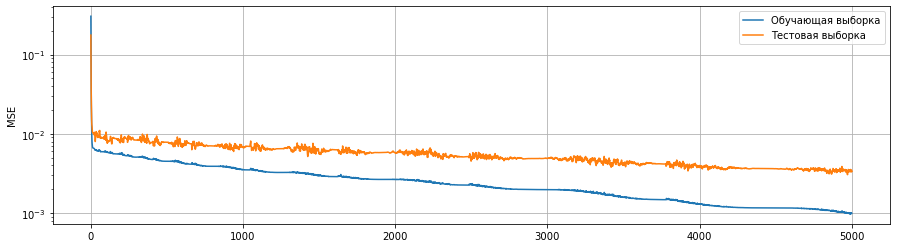

In [26]:
model4 = make_model_4()

schedule = SGDRScheduler(min_lr=1e-5,
                         max_lr=1e-2,
                         steps_per_epoch=1,    
                         lr_decay=1,
                         cycle_length=50,
                         mult_factor=1.5)

history = model4.fit(x_train, normalize(y_train, y_train),
                     validation_data=(x_test, normalize(y_test, y_train)),
                     epochs=5000,
                     verbose=0,
                     callbacks=[schedule])
plot_history(history)

In [27]:
train_err_4 = model4.evaluate(x_train, normalize(y_train, y_train), verbose=0)
test_err_4 = model4.evaluate(x_test, normalize(y_test, y_train), verbose=0)

print('Ошибка на обучающей выборке: %.3f, ошибка на тестовой выборке: %.3f' % (train_err_4, test_err_4))

Ошибка на обучающей выборке: 0.001, ошибка на тестовой выборке: 0.004


In [28]:
h = schedule.history
print(h.keys())

dict_keys(['lr', 'loss'])


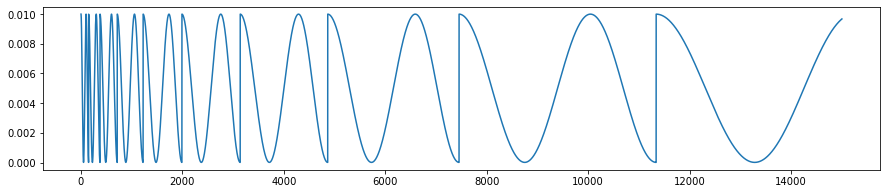

In [29]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(h['lr'])
plt.show()

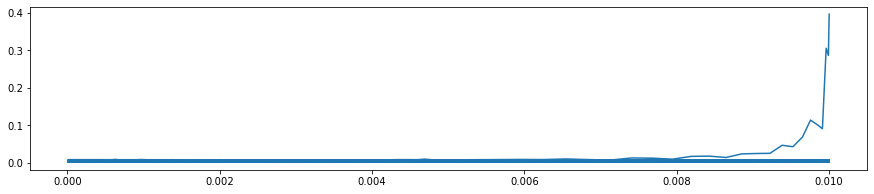

In [30]:
lr = h['lr']
acc = h['loss']

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(lr, acc)

plt.show()

Перед тем, как приступить к заданию 2, попробую подытожить те результаты, которые у меня получились, и опираться на них при решении. 

In [32]:
print("tanh/SGD: обучающая выборка: %.3f, тестовая выборка: %.3f" % (train_err_1, test_err_1))
print("relu/Adam: обучающая выборка: %.3f, тестовая выборка: %.3f" % (train_err_2, test_err_2))
print("relu/Adam c затуханием скорости обучения: обучающая выборка: %.3f, тестовая выборка: %.3f" % (train_err_3, test_err_3))
print("tanh/SGD c циклическим изменением скорости обучения: обучающая выборка: %.3f, тестовая выборка: %.3f" % (train_err_4, test_err_4))

tanh/SGD: обучающая выборка: 0.005, тестовая выборка: 0.008
relu/Adam: обучающая выборка: 0.000, тестовая выборка: 0.002
relu/Adam c затуханием скорости обучения: обучающая выборка: 0.000, тестовая выборка: 0.003
tanh/SGD c циклическим изменением скорости обучения: обучающая выборка: 0.001, тестовая выборка: 0.004


Лучший результат по-прежнему у relu/Adam, вариант с затуханием скорости обучения к нему максимально приближен (значения лучше, чем в оригинальном примере) и на мой взгляд такой результат является в принципе вполне приемлимым. 

**Задание 2**

1. Попробую улучшить результат для relu/Adam путем использования Dropout

In [48]:
def make_model_5():
    model = Sequential()
    normLayer = Normalization()
    normLayer.adapt(x_train)
    model.add(normLayer)
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer= keras.optimizers.Adam(learning_rate=0.001))
    return model

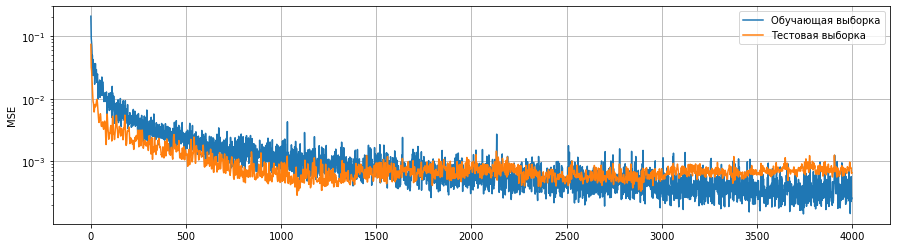

In [61]:
model5 = make_model_5()
history = model5.fit(x_train, normalize(y_train, y_train),
                     validation_data=(x_test, normalize(y_test, y_train)),
                     epochs=4000,
                     verbose=0)
plot_history(history)

In [63]:
train_err_5 = model5.evaluate(x_train, normalize(y_train, y_train), verbose=0)
test_err_5 = model5.evaluate(x_test, normalize(y_test, y_train), verbose=0)

print('Ошибка на обучающей выборке: %.3f, ошибка на тестовой выборке: %.3f' % (train_err_5, test_err_5))

Ошибка на обучающей выборке: 0.003, ошибка на тестовой выборке: 0.001


Вывод: стало как-то хуже чем было - ошибка на тестовой выборке даже превзошла результат обычного relu/Adam, но при этом обучение стало нестабильным и выборки снова поменялись местами, как это было для ненормализованных данных в самом начале. 

2. Теперь попробую применить batchNormalization к tanh/SGD

In [56]:
def make_model_6():
    model = Sequential()
    normLayer = Normalization()
    normLayer.adapt(x_train)
    model.add(normLayer)
    model.add(Dense(100, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dense(30, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer= keras.optimizers.SGD(learning_rate=0.001))
    return model

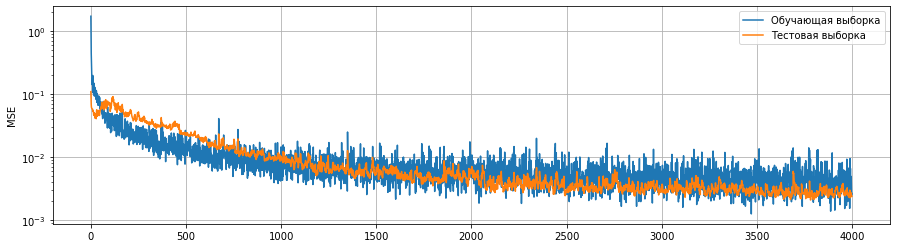

In [59]:
model6 = make_model_6()
history = model6.fit(x_train, normalize(y_train, y_train),
                     validation_data=(x_test, normalize(y_test, y_train)),
                     epochs=4000,
                     verbose=0)
plot_history(history)

In [60]:
train_err_6 = model6.evaluate(x_train, normalize(y_train, y_train), verbose=0)
test_err_6 = model6.evaluate(x_test, normalize(y_test, y_train), verbose=0)

print('Ошибка на обучающей выборке: %.3f, ошибка на тестовой выборке: %.3f' % (train_err_6, test_err_6))

Ошибка на обучающей выборке: 0.001, ошибка на тестовой выборке: 0.002


Вывод: ошибка на тестовой выборке сравнялась с лучшим результатом на данный момент - relu/Adam. Обучение опять-таки потеряло стабильность, а выборки периодически опять "меняются местами". 

3. Теперь попробую сочетание relu/SGD

In [75]:
def make_model_7():
    model = Sequential()
    normLayer = Normalization()
    normLayer.adapt(x_train)
    model.add(normLayer)
    model.add(Dense(100, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.001))
    return model

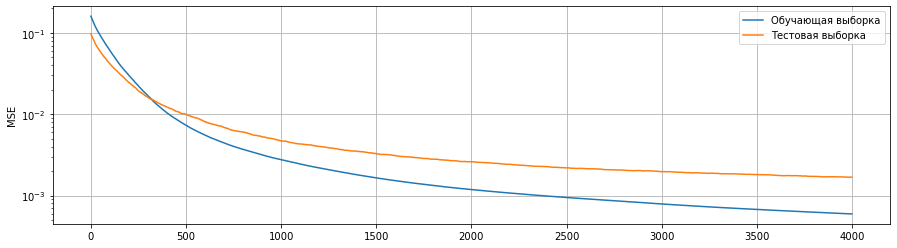

In [76]:
model7 = make_model_7()
history = model7.fit(x_train, normalize(y_train, y_train),
                     validation_data=(x_test, normalize(y_test, y_train)),
                     epochs=4000,
                     verbose=0)
plot_history(history)

In [77]:
train_err_7 = model7.evaluate(x_train, normalize(y_train, y_train), verbose=0)
test_err_7 = model7.evaluate(x_test, normalize(y_test, y_train), verbose=0)

print('Ошибка на обучающей выборке: %.3f, ошибка на тестовой выборке: %.3f' % (train_err_7, test_err_7))

Ошибка на обучающей выборке: 0.001, ошибка на тестовой выборке: 0.002


Вывод: результат на тестовой выборке повторяет результат для relu/Adam, но при этом обучение выглядит более устойчивым

4. Теперь добавлю метод Нестерова к relu/SGD

In [78]:
def make_model_8():
    model = Sequential()
    normLayer = Normalization()
    normLayer.adapt(x_train)
    model.add(normLayer)
    model.add(Dense(100, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.001, nesterov=True))
    return model

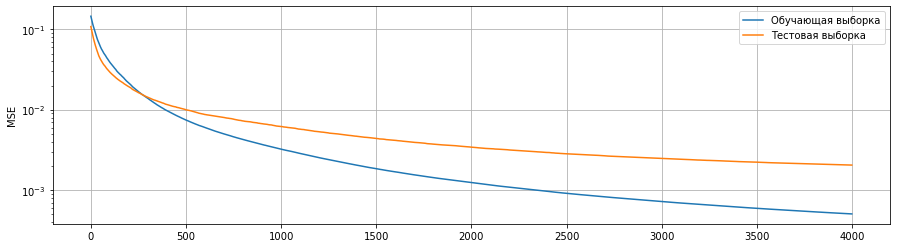

In [79]:
model8 = make_model_8()
history = model8.fit(x_train, normalize(y_train, y_train),
                     validation_data=(x_test, normalize(y_test, y_train)),
                     epochs=4000,
                     verbose=0)
plot_history(history)

In [80]:
train_err_8 = model8.evaluate(x_train, normalize(y_train, y_train), verbose=0)
test_err_8 = model8.evaluate(x_test, normalize(y_test, y_train), verbose=0)

print('Ошибка на обучающей выборке: %.3f, ошибка на тестовой выборке: %.3f' % (train_err_8, test_err_8))

Ошибка на обучающей выборке: 0.001, ошибка на тестовой выборке: 0.002


Вывод: результат на тестовой выборке снова повторяет результат для relu/Adam, но при этом обучение выглядит более устойчивым + по сравнению с предыдущим результатом ошибка для тестовой выборки падает чуть медленнее.

На мой взгляд наиболее удачным из всех экспериментов оказалось сочетание relu/SGD. Чуть ниже я попробую обучить выбранную модель на большем числе эпох.

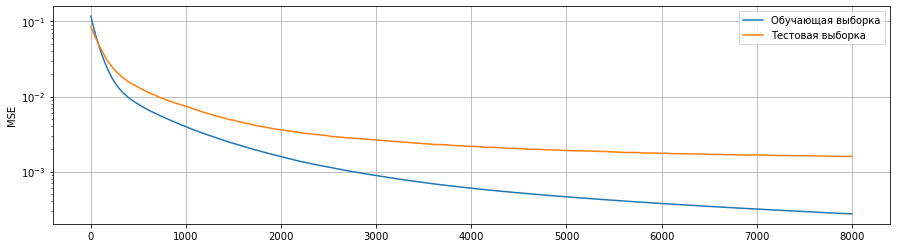

In [81]:
model9 = make_model_7()
history = model9.fit(x_train, normalize(y_train, y_train),
                     validation_data=(x_test, normalize(y_test, y_train)),
                     epochs=8000,
                     verbose=0)
plot_history(history)

In [82]:
train_err_9 = model9.evaluate(x_train, normalize(y_train, y_train), verbose=0)
test_err_9 = model9.evaluate(x_test, normalize(y_test, y_train), verbose=0)

print('Ошибка на обучающей выборке: %.3f, ошибка на тестовой выборке: %.3f' % (train_err_9, test_err_9))

Ошибка на обучающей выборке: 0.000, ошибка на тестовой выборке: 0.002


Вывод: был полностью повторен результат ошибки для relu/Adam на обоих выборках, но при этом обучение намного более стабильно. Для дальнейших заданий я буду использовать последнюю построенную модель данных (model 9, relu/Adam). Добится переобучения на использованных данных не получилось ни на одной модели. 

В задании также был вопрос про количество нейронов в сети. Поскольку лучший способ проверить - поэкспериментировать, то я попробую взять выбранную выше модель, как наилучшую, уменишить в ней количество нейронов и сравнить результат. 

In [87]:
def make_model_10():
    model = Sequential()
    normLayer = Normalization()
    normLayer.adapt(x_train)
    model.add(normLayer)
    model.add(Dense(50, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.001))
    return model

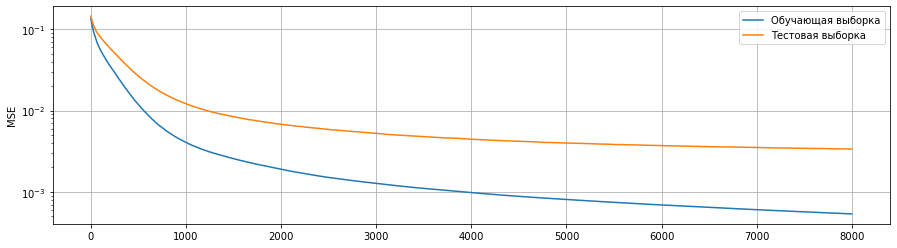

In [88]:
model10 = make_model_10()
history = model10.fit(x_train, normalize(y_train, y_train),
                     validation_data=(x_test, normalize(y_test, y_train)),
                     epochs=8000,
                     verbose=0)
plot_history(history)

In [89]:
train_err_10 = model10.evaluate(x_train, normalize(y_train, y_train), verbose=0)
test_err_10 = model10.evaluate(x_test, normalize(y_test, y_train), verbose=0)

print('Ошибка на обучающей выборке: %.3f, ошибка на тестовой выборке: %.3f' % (train_err_10, test_err_10))

Ошибка на обучающей выборке: 0.001, ошибка на тестовой выборке: 0.003


При уменьшении количества нейронов в два раза ошибка на обоих выборках стала больше, но не намного. 

In [90]:
def make_model_11():
    model = Sequential()
    normLayer = Normalization()
    normLayer.adapt(x_train)
    model.add(normLayer)
    model.add(Dense(10, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.001))
    return model

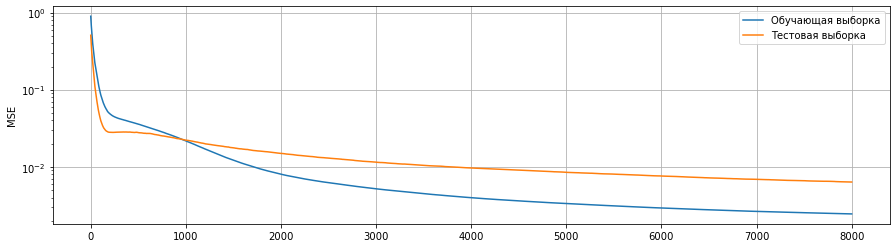

In [91]:
model11 = make_model_11()
history = model11.fit(x_train, normalize(y_train, y_train),
                     validation_data=(x_test, normalize(y_test, y_train)),
                     epochs=8000,
                     verbose=0)
plot_history(history)

In [92]:
train_err_11 = model11.evaluate(x_train, normalize(y_train, y_train), verbose=0)
test_err_11 = model11.evaluate(x_test, normalize(y_test, y_train), verbose=0)

print('Ошибка на обучающей выборке: %.3f, ошибка на тестовой выборке: %.3f' % (train_err_11, test_err_11))

Ошибка на обучающей выборке: 0.002, ошибка на тестовой выборке: 0.006


При уменьшении количества нейронов в 10 раз ошибка стала заметно больше в несколько раз. Из этого в целом можно сделать вывод, что количество нейронов можно в целом сократить, но не слишком сильно. Оптимально, наверное, раза в 1.5-2. 

**Задание 3** 

In [83]:
x_validate, y_validate = make_friedman2(n_samples=100, noise=0, random_state=3)
validate_err = model9.evaluate(x_validate, normalize(y_validate, y_train), verbose=0)

In [86]:
print('Ошибка на валидационной выборке: %.3f' % (validate_err))

Ошибка на валидационной выборке: 0.001


Вывод: как и было описано ранее, была использована последняя обученная модель relu/Adam. Ошибка на новых данных даже меньше, чем на тестовой выборке, следовательно сеть не переобучена. Кстати, посмотрим как на этих значения будут себя вести "уменьшенные копии".

In [93]:
validate_err_1 = model10.evaluate(x_validate, normalize(y_validate, y_train), verbose=0)
print('Ошибка на валидационной выборке: %.3f' % (validate_err_1))

Ошибка на валидационной выборке: 0.001


Сеть, уменьшенная в 2 раза, показала ровно такой же результат. 

In [94]:
validate_err_2 = model11.evaluate(x_validate, normalize(y_validate, y_train), verbose=0)
print('Ошибка на валидационной выборке: %.3f' % (validate_err_2))

Ошибка на валидационной выборке: 0.004


Сеть, уменьшенная в 10 раза, показала в 4 раза большую ошибку. 

**Задание 4**

Для выполнения этого задания возьмем ту же комбинацию relu/SGD и исходный размер сети. Попробуем провести пакетное обучение сначала на данных без шума, а потом на данных с шумом и сравним полученные результаты. 

In [106]:
def make_base_model():
    model = Sequential()
    normLayer = Normalization()
    normLayer.adapt(x_train)
    model.add(normLayer)
    model.add(Dense(100, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.001))
    return model

In [133]:
batch_size = 50

def create_packet(param):
    packet_x_train = []
    packet_x_test = []
    packet_y_train = []
    packet_y_test = []

    for i in range(batch_size):
        x_iter, y_iter = make_friedman2(n_samples=100, noise=param, random_state=5)
        n_train = 70
        packet_x_train.append(x[:n_train, :])
        packet_x_test.append(x[n_train:, :])
        packet_y_train.append(y[:n_train])
        packet_y_test.append(y[n_train:])
    return np.array(packet_x_train), np.array(packet_y_train), np.array(packet_x_test), np.array(packet_y_test)

In [134]:
x_train_with_noise, y_train_with_noise, x_test_with_noise, y_test_with_noise = create_packet(20.)

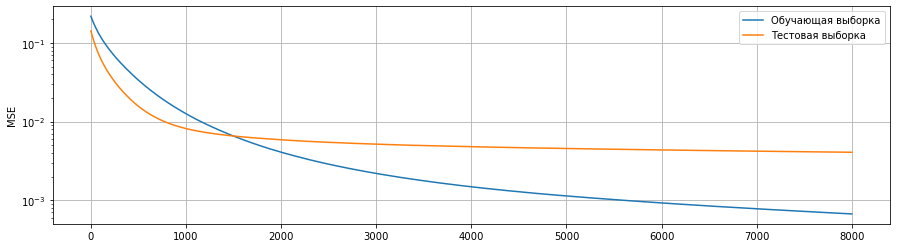

Ошибка на обучающей выборке: 0.001, ошибка на тестовой выборке: 0.004


In [135]:
model_with_noise = make_base_model()
history = model_with_noise.fit(x_train_with_noise, normalize(y_train_with_noise, y_train),
                     validation_data=(x_test_with_noise, normalize(y_test_with_noise, y_train)),
                     batch_size=batch_size,
                     epochs=8000,
                     verbose=0)
plot_history(history)

train_err_with_noise = model_with_noise.evaluate(x_train_with_noise, normalize(y_train_with_noise, y_train), verbose=0)
test_err_with_noise = model_with_noise.evaluate(x_test_with_noise, normalize(y_test_with_noise, y_train), verbose=0)

print('Ошибка на обучающей выборке: %.3f, ошибка на тестовой выборке: %.3f' % (train_err_with_noise, test_err_with_noise))

In [136]:
x_train_without_noise, y_train_without_noise, x_test_without_noise, y_test_without_noise = create_packet(0.)

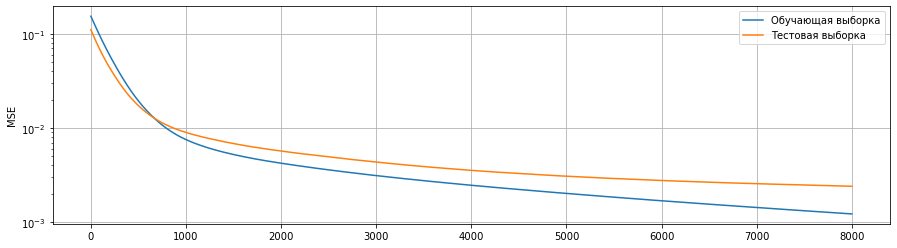

Ошибка на обучающей выборке: 0.001, ошибка на тестовой выборке: 0.002


In [137]:
model_without_noise = make_base_model()
history = model_without_noise.fit(x_train_without_noise, normalize(y_train_without_noise, y_train),
                     validation_data=(x_test_without_noise, normalize(y_test_without_noise, y_train)),
                     batch_size=batch_size,
                     epochs=8000,
                     verbose=0)
plot_history(history)

train_err_without_noise = model_without_noise.evaluate(x_train_without_noise, normalize(y_train_without_noise, y_train), verbose=0)
test_err_without_noise = model_without_noise.evaluate(x_test_without_noise, normalize(y_test_without_noise, y_train), verbose=0)

print('Ошибка на обучающей выборке: %.3f, ошибка на тестовой выборке: %.3f' % (train_err_without_noise, test_err_without_noise))

Вывод: Было сгенерировано 50 пакетов с 70 точками обучающего набора и 30 проверочного. Одна модель обучалась на данных без шума, другая - с шумом. На обучающей выборке модели показали одинаковый результат, в то время как на тестовой ошибка модели на данных без шума в 2 раза меньше. Т.е. некоторая зависимость от наличия шума имеет место быть. Предполагаю, что ошибка меньше во втором случае (без шума) так как данные более упорядочены и во-первых зависимость найти проще, а во-вторых она не искажена. 